In [1]:
# import sys
# sys.path.append('../Scripts')
# from PostProcessingScripts import * 
# import pandas as pd 
# import string 

# just to make the cells appear wider:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import units as u
from astropy import constants as c
# import pandas as pd
# import string


In [29]:
def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 25, second=False, labelpad=None, setMinor=True, ):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')


    if labelSizeMajor==10:
        ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
        ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    else:
        ax.set_xlabel(nameX, fontsize=labelSizeMajor,labelpad=labelpad)#,fontweight='bold')
        ax.set_ylabel(nameY, fontsize=labelSizeMajor,labelpad=labelpad)#, fontweight='bold')  

    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax

In [82]:
class calculate_spin(object):
    """
    This class calculates the Black Hole (BH) or Neutron Star (NS) spin based on a given spin prescription
    It returns the spin of the compact object M1, and compact object M2
    The available spin prescriptions are:
    []
    
    """

    
    def __init__(self, data_path=None, spin_model='uniform'):
    
        self.path                = data_path
        
        if (self.path is None):
            print("Warning: your hdf5 path is set to 'None'")
        elif not  os.path.isfile(data_path):
            raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%data_path)
        elif os.path.isfile(data_path):
            self.h5file           = h5.File(data_path)
            
            
        self.spin_model = spin_model
        
        
    def random_uniform_spin(self, low, high):   
        import random
        
        sample_size = len(self.h5file['doubleCompactObjects']['M1'][...].squeeze())
        
        self.spinM1 = np.random.uniform(low=low, high=high, size=sample_size)
        self.spinM2 = np.random.uniform(low=low, high=high, size=sample_size)
        
        
        return self.spinM1, self.spinM2
    
    
    def fixed_value_spin(self, spin_value):   
        
        M1samples = self.h5file['doubleCompactObjects']['M1'][...].squeeze()
        
        self.spinM1 = np.ones_like(a=M1samples) * spin_value
        self.spinM2 = np.ones_like(a=M1samples) * spin_value
        
        
        return self.spinM1, self.spinM2
    
        
    def setCOMPASData(self):
        """ reads in some of the COMPAS parameters needed from hdf5 file """
        
        fDCO      = self.h5file['doubleCompactObjects'] # hdf5 file with the DCO information
        fSN       = self.h5file['supernovae']  # hdf5 file with the SN information
        #
        self.M1 = fDCO['M1'][...].squeeze()   # Compact object mass [Msun] of the initially more massive star
        self.M2 = fDCO['M2'][...].squeeze()  # Compact object mass [Msun] of the initially less massive star
        self.metallicitySystems  = fDCO['Metallicity1'][...].squeeze() 
        
        self.seedsDCO = fDCO['seed'][...].squeeze()  # get the seeds in the DCO file 
        self.seedsSN = fSN['randomSeed'][...].squeeze()    # get the seeds in the SN file 
        maskSNdco = np.in1d(self.seedsSN,  self.seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
        whichSN = fSN['whichStar'][...].squeeze()[maskSNdco]   # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova
        whichSN2 = whichSN[1::2] # get whichStar for the first SN   (there are 2 SNe for all DCOs)       
        
        self.separationPreSN2= fSN['separationBefore'][...].squeeze()[maskSNdco][1::2] # the separation just before each SN  in [Rsun], we need only the separation for the second SN to occur, so the [1::2]  

        self.convert_a_to_P_circular(separation=self.separationPreSN2*u.Rsun, M1=self.M1*u.Msun, M2=self.M2*u.Msun)  # obtain the Period before the SNe
        self.PeriodPreSN2 = self.PeriodPreSN2.to(u.d).value
        self.MassCOCoreSN = fSN['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
        
        self.st1 = fDCO['stellarType1'][...].squeeze()   # obtain the final stellar type of the Primary 
        self.st2 = fDCO['stellarType2'][...].squeeze()   # obtain the final stellar type of the Secondary
        
        self.spinM1, self.spinM2 = np.zeros_like(self.M1), np.zeros_like(self.M2)  # start by giving all primaries zero spin and all secondaries zero spin 
        # did M1 form in the first SN?
        self.M1formedSecond =  (whichSN2==1) # mask that is 1 if the  compact object M1 formed first in the DCO
        # did M2 form in the first SN?
        self.M2formedSecond =  (whichSN2==2)  # mask that is 1 if the compact object M2 formed first in the DCO
        mask_SN1not1or2 = (whichSN2!=1) & (whichSN2!=2)
        
        
#         self.mWR =  fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
        self.mWR =  fSN['MassStarSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe


    def function_f_Bavera21(self, c1, c2, c3):
        """
        m_WR with units using astropy


        """

        top = -c1
        bottom = c2 + np.exp(-c3*self.mWR)

        f = top/bottom


        return f  
    
   
    def convert_a_to_P_circular(self, separation, M1, M2):
        """calculate Period from separation
        separation is separation (needs to be given in astropy units)
        M1 and M2 are masses of the binary

        """
        G = c.G # [gr cm s^2]


        mu = G*(M1+M2)
        self.PeriodPreSN2 = 2*np.pi * np.sqrt(separation**3/mu)

          
    def calculate_alpha_beta_Bavera21(self):
        
        # numerical coefficients form text below Eq 2
        # we use the values at helium depletion, since we later on use the C/O core mass. 
        c1_alpha, c2_alpha, c3_alpha =  0.059305, 0.035552, 0.270245
        c1_beta,  c2_beta, c3_beta   =  0.026960, 0.011001, 0.420739

        alpha = self.function_f_Bavera21(c1_alpha, c2_alpha, c3_alpha)
        beta  = self.function_f_Bavera21(c1_beta,  c2_beta,  c3_beta)

        return alpha, beta



        
        
    def Bavera_spin(self):
        """
        Returns spinM1 and spinM2, the spins of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this approximation only a BH that is formed second can be tidally spun up, if its 
        pre-SN separation is tight enough. 

        based on Eq 1 and 2 from https://arxiv.org/pdf/2105.09077.pdf
    
    
        """
        
        # the following function reads in the COMPAS DCO parameters such as WR mass and sets self.spinM1, self.spinM2 
        # to arrays of zeros
        self.setCOMPASData() 
        
        ## Calculate spin for the ones that tidally spin up ##
        
        alpha, beta = self.calculate_alpha_beta_Bavera21()  #obtain alpha and beta 
        
        # define mask of BHs that can have spin through tidal spin up
        # if BH (self.st==14) & formed second (self.M1formedFirst==0) & has pre-SN period (WR-BH period) of < 1 day, calculate spin with the approximation
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedSecond==1)) & (np.log10(self.PeriodPreSN2) < 1)
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedSecond==1)) & (np.log10(self.PeriodPreSN2) < 1)
        
        # Bavera approximation: 
        first_term = (alpha* (np.log10(self.PeriodPreSN2)**2)) 
        second_term =  ( beta * np.log10(self.PeriodPreSN2))  
        self.spinM1[maskGiveSpin1]  =  first_term[maskGiveSpin1]  + second_term[maskGiveSpin1]  
        self.spinM2[maskGiveSpin2]  =  first_term[maskGiveSpin2]  + second_term[maskGiveSpin2] 
        
        #for some binaries the properties fall outside of the fit, we set these artificial to spin 0 
        n_negative_spin1 = np.sum(self.spinM1<0)
        self.spinM1[self.spinM1<0] = np.zeros(n_negative_spin1)
        n_negative_spin2 = np.sum(self.spinM2<0)
        self.spinM2[self.spinM2<0] = np.zeros(n_negative_spin2)
        
        
        return self.spinM1, self.spinM2
    
    
    
    
    def QinSpin(self):
        """
        Returns spinM1 and spinM2, the spins of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this approximation only a BH that is formed second can be tidally spun up, if its 
        pre-SN separation is tight enough. 
        
        see Qin+18, approximation originally given in https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3682C 
        (and Equation 5 in https://arxiv.org/pdf/2103.02608.pdf)
        
        """
        
        # the following function reads in the COMPAS DCO parameters such as WR mass and sets self.spinM1, self.spinM2 
        # to arrays of zeros
        self.setCOMPASData() 
        
        m_, c_ = -5./3, 0.5 # from Qin + 2018 

        # if BH & formed second and tight enought at WR-BH phase, calculate spin with Qin+18 approximation for systems that have spin 1 
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedSecond==1) &  (np.log10(self.PeriodPreSN2) < -0.3))
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedSecond==1) &  (np.log10(self.PeriodPreSN2) < -0.3))
        # the systems above have maximum spin
        self.spinM1[maskGiveSpin1] = np.ones(np.sum(maskGiveSpin1)) # fill with ones 
        self.spinM2[maskGiveSpin2] = np.ones(np.sum(maskGiveSpin2)) # fill with ones 
  
        
        # now assign the spin for systems that lie in between the 0 and 1 spin using the fitting formulae
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedSecond==1) &  (np.log10(self.PeriodPreSN2) >= -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3))
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedSecond==1) &  (np.log10(self.PeriodPreSN2) >= -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3))

        self.spinM1[maskGiveSpin1] =  m_ * np.log10(self.PeriodPreSN2[maskGiveSpin1])  + c_   
        self.spinM2[maskGiveSpin2] =  m_ * np.log10(self.PeriodPreSN2[maskGiveSpin2])  + c_   
              
    
        return self.spinM1, self.spinM2

    
    
    def Z_dependent_spin_param(self, metallicity_range, prescription_name):
        """ 
        prescription_name in [Geneva, MESA]
        """
        # from Table 1 in http://arxiv.org/abs/2301.01312 


        if metallicity_range >= 0.010:
            return [2.58, 16.0, 24.2, 0.13] if prescription_name=='Geneva' else  [-0.0016, 0.115, np.inf, np.inf, np.inf]

        elif (metallicity_range >= 0.004) & (metallicity_range < 0.010):
            return [3.578, 31.0, 37.8, 0.25] if prescription_name=='Geneva' else  [-0.0006, 0.105, np.inf, np.inf, np.inf]

        elif (metallicity_range >= 0.0012) & (metallicity_range < 0.004):
            return [2.434, 18.0, 27.7, 0.0 ] if prescription_name=='Geneva' else  [-0.0076, 0.050, -0.0019, 0.165, 12.09]


        elif (metallicity_range < 0.0012):
            return [3.666, 32.0, 38.8, 0.25] if prescription_name=='Geneva' else  [-0.0010, 0.125, np.inf, np.inf, np.inf]


    def GenevaSpin(self):
        # see from Table 1 in http://arxiv.org/abs/2301.01312 


        Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]] # Tab. 1 conditions in  in http://arxiv.org/abs/2301.01312 

        self.setCOMPASData()
        for _, Z_range in enumerate(Z_ranges):
            mask_inside_Z = (self.metallicitySystems >= Z_range[0]) & (self.metallicitySystems < Z_range[1]) # mask inside metallicity range
            print(Z_range[0])
            b_, m1_, m2_, a_low = self.Z_dependent_spin_param(metallicity_range=Z_range[0], prescription_name='Geneva')


            self.spinM1[self.mWR <= m1_], self.spinM2[self.mWR <= m1_] = 0.85, 0.85
            mask_spin = (self.mWR > m1_) &  (self.mWR < m2_)
            self.spinM1[mask_spin], self.spinM2[mask_spin] = -0.088*self.mWR[mask_spin] + b_, -0.088*self.mWR[mask_spin] + b_
            self.spinM1[self.mWR >= m2_], self.spinM2[self.mWR >= m2_] = a_low, a_low
    
        return self.spinM1, self.spinM2
    
    
    def MESASpin(self):
        # see from Table 1 in http://arxiv.org/abs/2301.01312 

        self.setCOMPASData()
        
        Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]] # Tab. 1 conditions in  in http://arxiv.org/abs/2301.01312 


        for _, Z_range in enumerate(Z_ranges):
            mask_inside_Z = (self.metallicitySystems >= Z_range[0]) & (self.metallicitySystems < Z_range[1]) # mask inside metallicity range
            b_, m1_, m2_, a_low = self.Z_dependent_spin_param(metallicity_range=Z_range[0], prescription_name='MESA')


            self.spinM1[self.mWR <= m1_], self.spinM2[self.mWR <= m1_] = 0.85, 0.85
            mask_spin = (self.mWR > m1_) & (self.mWR < m2_)
            self.spinM1[mask_spin], self.spinM2[mask_spin] = -0.088*self.mWR[mask_spin] + b_, -0.088*self.mWR[mask_spin] + b_
            self.spinM1[self.mWR >= m2_], self.spinM2[self.mWR >= m2_] = a_low, a_low


        return self.spinM1, self.spinM2
    
        
    
    


In [3]:
DCOtype='BBH'
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 

spin = calculate_spin(data_path=path, spin_model='Bavera21')

spinM1, spinM2  = spin.random_uniform_spin(low=0.6,high=1)

spinM1, spinM2  = spin.fixed_value_spin(spin_value=0.5)
print(spinM1)



[0.5 0.5 0.5 ... 0.5 0.5 0.5]
8371398 8371398 8371398

 debugging
[  6.06026   3.84904  20.5538  ... 106.062    38.9903  120.297  ] solRad
[33.4712  17.0417  14.5644  ...  5.15439  5.54399  5.15051] solMass
[17.9509   8.03394 14.9915  ...  3.74582  3.22212  3.84802] solMass
[1.60007002e+06 1.15979072e+06 1.31823580e+07 ... 2.81589592e+08
 6.32424103e+07 3.38277738e+08] kg(1/2) s solRad(3/2) / (m(3/2) solMass(1/2))
[1.60007002e+06 1.15979072e+06 1.31823580e+07 ... 2.81589592e+08
 6.32424103e+07 3.38277738e+08] kg(1/2) s solRad(3/2) / (m(3/2) solMass(1/2))
not 1 or 2 but: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0.9192879  0.69223441 0.21643183 ... 0.12644115 0.18899195 0.17173468]


In [41]:
def plot_scatter_spin(spin_values, spin_model):




    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.scatter(spin.mWR[0:100000], spin.PeriodPreSN2[0:100000],  c=spin_values[0:100000])



    ylabel=r'Period [day]'
    xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '

    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1, 70)
    plt.ylim(0.05, 10)

    cbar = plt.colorbar()
    cbar.set_label('spin', fontsize=20)
    cbar.ax.tick_params(labelsize='large')

    plt.title('spin' + spin_model)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    # plt.savefig('./BBH_COMPAS_model_A.png', dpi=600)#,\
    plt.show()



def plot_histogram_spin(spin_values, spin_model, weights):




    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.hist(spin_values[0:], weights=weights[0:], bins=100)



    ylabel=r'PDF (rate) $Gpc^{-3} yr^{-1}$' 
    xlabel=r'spin '

#     plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0, 1)
#     plt.ylim(0.0, 1)


    plt.title('spin' + spin_model)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    # plt.savefig('./BBH_COMPAS_model_A.png', dpi=600)#,\
    plt.show()




## Bavera Spin 

In [83]:
DCOtype='BBH'
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 

spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.Bavera_spin()



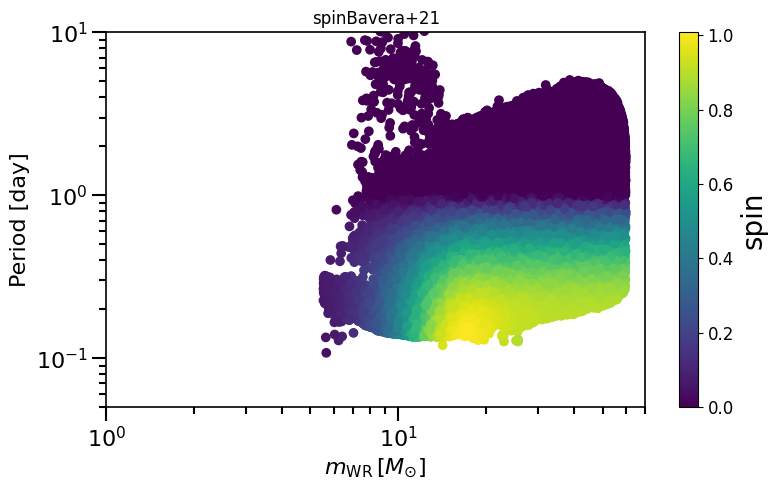

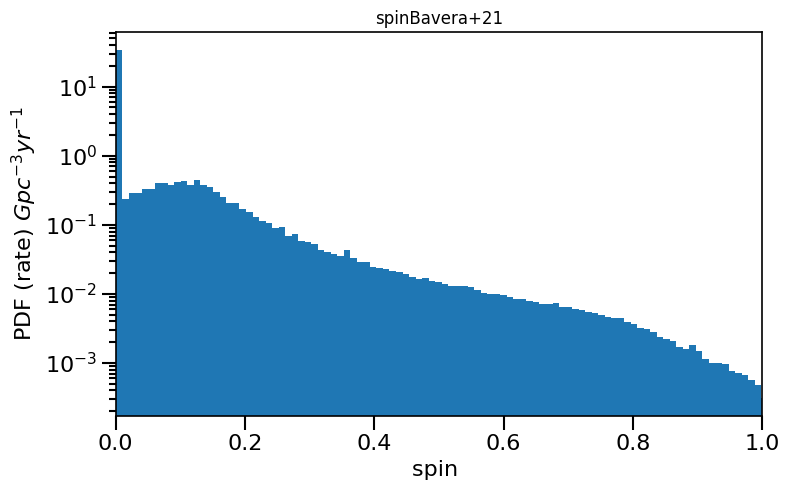

In [84]:
plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model='Bavera+21')

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model='Bavera+21', weights=w_intrinsic)


## spin Geneva (birth)

0.0
0.0012
0.004
0.01


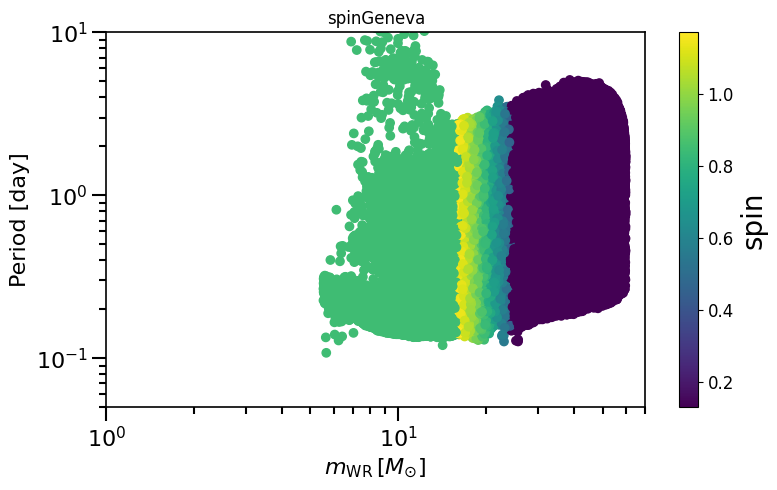

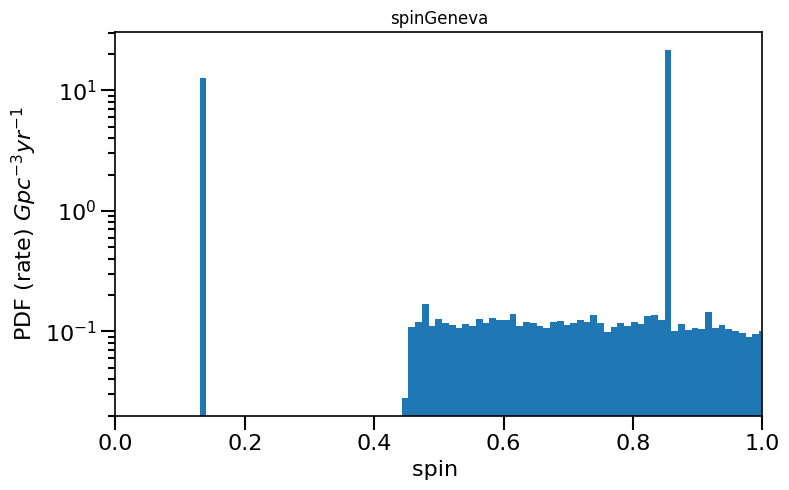

In [79]:
spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.GenevaSpin()


plot_scatter_spin(spin_values=(spinM1), spin_model='Geneva')

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

plot_histogram_spin(spin_values=(spinM1), spin_model='Geneva', weights=w_intrinsic)


## spin MESA (birth)

In [ ]:
# spin = calculate_spin(data_path=path)
# spinM1, spinM2  = spin.MESASpin()


# plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model='MESA')

# fdata = h5.File(path)
# w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

# plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model='MESA', weights=w_intrinsic)


# BHNS

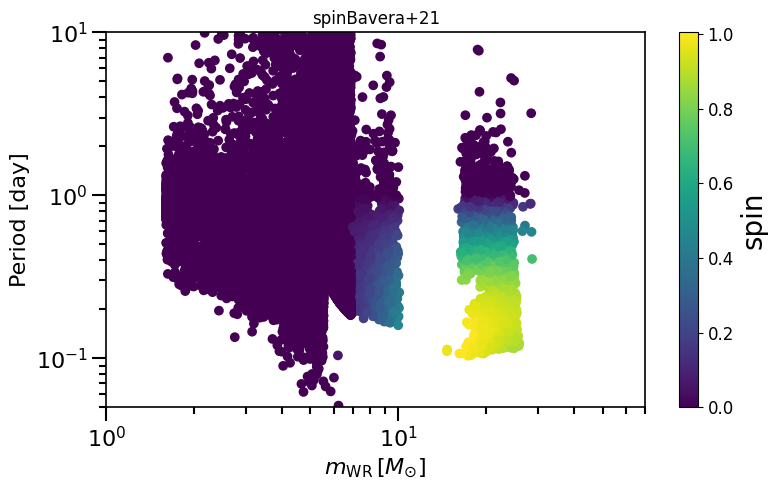

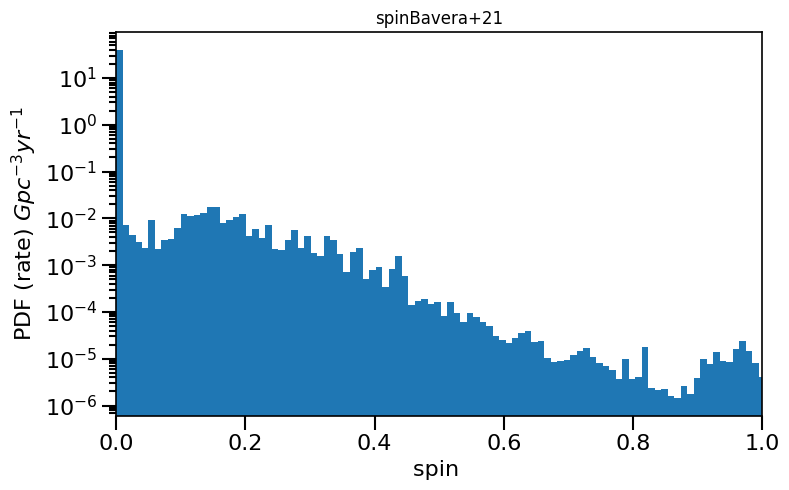

In [81]:
DCOtype='BHNS'
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 

spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.Bavera_spin()


plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model='Bavera+21')

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model='Bavera+21', weights=w_intrinsic)


In [46]:




# class calculate_spin(object):
#     """
#     This class calculates the Black Hole (BH) or Neutron Star (NS) spin
#     based on a given spin function/model.  
    
#     """
    
    
#     def __init__(self, data_path=None, SFRDmodel='312'):
    
#         self.path                = data_path
#         if (self.path is None):
#             print("Just to double check you create instance of ClassCOMPAS without path/Data")
#         elif not  os.path.isfile(data_path):
#             raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%data_path)
#         elif os.path.isfile(data_path):
#             self.h5file           = h5.File(data_path)
            
            
#         self.spin_model = None 
#         self.whichweight = None 
#         self.SFRDmodel = SFRDmodel  # SFRD model chosen for the weights 
    
        
  
        
        
#     def setCOMPASData(self):
#         """ reads in some of the COMPAS parameters needed from hdf5 file """
        
#         fDCO      = self.h5file['doubleCompactObjects'] # hdf5 file with the DCO information
#         fSN       = self.h5file['supernovae']  # hdf5 file with the SN information
#         #
#         self.M1 = fDCO['M1'][...].squeeze()   # Compact object mass [Msun] of the initially more massive star
#         self.M2 = fDCO['M2'][...].squeeze()  # Compact object mass [Msun] of the initially less massive star
#         self.metallicitySystems  = fDCO['Metallicity1'][...].squeeze()
        
#         if self.whichweight =='DCOweights':
#             self.weight  = fDCO['weight'][...].squeeze()  # system weights, these are representative of sampling that binary from the given metallicity in a galaxy.
#         elif self.whichweight =='detected':
#             self.weight  = fdata['weights_detected']['w_'+self.SFRDmodel]  # weights that account also for the detectability of the DCO and the star formation history (SFRD) 
#         elif self.whichweight =='intrinsic':
#             self.weight  = fdata['weights_intrinsic']['w_'+self.SFRDmodel]  # weights that account for the intrinsic rate (at redshift ~0) of the DCO for a given star formation history (SFRD) 
        
        
        
#         self.seedsDCO = fDCO['seed'][...].squeeze()  # get the seeds in the DCO file 
#         self.seedsSN = fSN['randomSeed'][...].squeeze()    # get the seeds in the SN file 
#         maskSNdco = np.in1d(self.seedsSN,  self.seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
#         whichSN = fSN['whichStar'][...].squeeze()[maskSNdco]   # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova
#         whichSN1 = whichSN[::2] # get whichStar for the first SN   (there are 2 SNe for all DCOs)       

#         self.separationPreSN2= fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco][1::2] # the separation just before each SN  in [Rsun], we need only the separation for the second SN to occur, so the [1::2]  
#         print(len(self.separationPreSN2), len(self.M1), len(self.M2))

#         self.PeriodPreSN2 = convert_a_to_P_circular(separation=self.separationPreSN2*u.Rsun, M1=self.M1*u.Msun, M2=self.M2*u.Msun)  # obtain the Period before the SNe
#         self.PeriodPreSN2 = self.PeriodPreSN2.to(u.d).value
#         self.MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
        
#         self.st1 = fDCO['stellarType1'][...].squeeze()   # obtain the final stellar type of the Primary 
#         self.st2 = fDCO['stellarType2'][...].squeeze()   # obtain the final stellar type of the Secondary
        
#         self.spinM1 = np.zeros_like(self.M1)  # start by giving all primaries zero spin 
#         self.spinM2 = np.zeros_like(self.M2)  # start by giving all secondaries zero spin 
#         # did M1 form in the first SN?
#         self.M1formedFirst =  (whichSN1==1) # mask that is 1 if the  compact object M1 formed first in the DCO
#         # did M2 form in the first SN?
#         self.M2formedFirst =  (whichSN1==2)  # mask that is 1 if the compact object M2 formed first in the DCO
# #         self.mWR =  fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
#         self.mWR =  fdata['supernovae']['MassStarSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe


    
#     def QinSpin(self):
#         """
#         Returns spinM1 and spinM2, the spins of the compact objects formed from
#         the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
#         In this approximation only a BH that is formed second can be tidally spun up, if its 
#         pre-SN separation is tight enough. 
        
#         see Qin+18, approximation originally given in https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3682C 
#         (and Equation 5 in https://arxiv.org/pdf/2103.02608.pdf)
        
#         """
        
#         m_, c_ = -5./3, 0.5 # from Qin + 2018 

#         # if BH & formed second, calculate spin with Qin+18 approximation
#         maskGiveSpin1 = ((self.st1==14) & (self.M1formedFirst==0))
#         maskGiveSpin2 = ((self.st2==14) & (self.M2formedFirst==0))
        
        
#         # # first mask super tight NSBH that will get spin 1
#         maskSpin1 = (np.log10(self.PeriodPreSN2) < -0.3) & (maskGiveSpin1 ==1)                        
#         maskSpin2 = (np.log10(self.PeriodPreSN2) < -0.3) & (maskGiveSpin2 ==1)
#         self.spinM1[maskSpin1] = np.ones(np.sum(maskSpin1)) # fill with ones 
#         self.spinM2[maskSpin2] = np.ones(np.sum(maskSpin2)) # fill with ones 
  
        
#         # now assign the spin for systems that lie in between the 0 and 1 spin using the fitting formulae
#         maskChi_var1 = (np.log10(self.PeriodPreSN2) > -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3)  &(maskGiveSpin1==1)
#         self.spinM1[maskChi_var1] =  m_ * np.log10(self.PeriodPreSN2[maskChi_var1])  + c_   
             
#         maskChi_var2 = (np.log10(self.PeriodPreSN2) > -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3)  &(maskGiveSpin2==1)
#         self.spinM2[maskChi_var2] =  m_ * np.log10(self.PeriodPreSN2[maskChi_var2])  + c_   
              
    
#         return self.spinM1, self.spinM2

    
    
#     def calculate_alpha_beta_Bavera21(self, c1_alpha, c2_alpha, c3_alpha,  c1_beta,  c2_beta,  c3_beta):


#         alpha = self.function_f_Bavera21(c1_alpha, c2_alpha, c3_alpha)
#         beta  = self.function_f_Bavera21(c1_beta,  c2_beta,  c3_beta)

#         return alpha, beta

#     def function_f_Bavera21(self, c1, c2, c3):
#         """
#         m_WR with units using astropy


#         """

#         top = -c1
#         bottom = c2 + np.exp(-c3*self.mWR)

#         f = top/bottom


#         return f        
        
        
#     def BaveraSpin(self):
#         """
#         Returns spinM1 and spinM2, the spins of the compact objects formed from
#         the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
#         In this approximation only a BH that is formed second can be tidally spun up, if its 
#         pre-SN separation is tight enough. 

#         based on Eq 1 and 2 from https://arxiv.org/pdf/2105.09077.pdf
    
    
#         """

#         # numerical coefficients form text below Eq 2
#         # we use the values at helium depletion, since we later on use the C/O core mass. 
#         c1_alpha, c2_alpha, c3_alpha =  0.059305, 0.035552, 0.270245
#         c1_beta,  c2_beta, c3_beta   =  0.026960, 0.011001, 0.420739
        
#         alpha, beta = self.calculate_alpha_beta_Bavera21(c1_alpha, c2_alpha, c3_alpha,  c1_beta,  c2_beta,  c3_beta)      
        

#         # if BH & formed second, calculate spin with Qin+18 approximation
#         maskGiveSpin1 = ((self.st1==14) & (self.M1formedFirst==0))
#         maskGiveSpin2 = ((self.st2==14) & (self.M2formedFirst==0))
        
#         # 
#         # mask shorter than 1 day & a BH formed second 
#         maskSpin1 = (np.log10(self.PeriodPreSN2) < 1) & (maskGiveSpin1 ==1)                        
#         maskSpin2 = (np.log10(self.PeriodPreSN2) < 1) & (maskGiveSpin2 ==1)
        
#         first_term = (alpha* (np.log10(self.PeriodPreSN2)**2)) 
#         second_term =  ( beta * np.log10(self.PeriodPreSN2))  
#         self.spinM1[maskSpin1]  =  first_term[maskSpin1]  + second_term[maskSpin1]  
#         self.spinM2[maskSpin2]  =  first_term[maskSpin2]  + second_term[maskSpin2] 
        
#         mask_ = (self.spinM1<0)
#         self.spinM1[self.spinM1<0] = np.zeros(np.sum(mask_))
#         mask_ = (self.spinM2<0)
#         self.spinM2[self.spinM2<0] = np.zeros(np.sum(mask_))
        
        
#     def Z_dependent_spin_param(self, metallicity, prescription_name):
#         """ 
#         prescription_name in [Geneva, MESA]
#         """
#         # from Table 1 in http://arxiv.org/abs/2301.01312 



#         if np.sqrt(num)%2 == 0:
#             return True
#         elif (np.sqrt(num)+1) % 2 == 0:
#             return True
#         else:
#             return False

#         if metallicity_range >= 0.010:
#             return [2.58, 16.0, 24.2, 0.13] if prescription_name=='Geneva' else  [-0.0016, 0.115, np.inf, np.inf, np.inf]

#         elif (metallicity_range >= 0.004) & (metallicity_range < 0.010):
#             return [3.578, 31.0, 37.8, 0.25] if prescription_name=='Geneva' else  [-0.0006, 0.105, np.inf, np.inf, np.inf]

#         elif (metallicity_range >= 0.0012) & (metallicity_range < 0.004):
#             return [2.434, 18.0, 27.7, 0.0 ] if prescription_name=='Geneva' else  [-0.0076, 0.050, -0.0019, 0.165, 12.09]


#         elif (metallicity_range < 0.0012):
#             return [3.666, 32.0, 38.8, 0.25] if prescription_name=='Geneva' else  [-0.0010, 0.125, np.inf, np.inf, np.inf]


#     def GenevaSpin(self):
#         # see from Table 1 in http://arxiv.org/abs/2301.01312 


#         Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]] # Tab. 1 conditions in  in http://arxiv.org/abs/2301.01312 


#         for _, Z_range in enumerate(Z_ranges):
#             mask_inside_Z = (self.metallicitySystems >= Z_range[0]) & (self.metallicitySystems < Z_range[1]) # mask inside metallicity range
#             b_, m1_, m2_, a_low = self.Z_dependent_Geneva_spin_param(self, metallicity=Z_range[0])


#             self.spinM1[self.mWR <= m1_], self.spinM2[self.mWR <= m1_] = 0.85, 0.85
#             self.spinM1[self.mWR > m1_ &  self.mWR < m2_], self.spinM2[self.mWR > m1_ &  self.mWR < m2_] = -0.088*self.mWR + b_, -0.088*self.mWR + b_
#             self.spinM1[self.mWR >= m2_], self.spinM2[self.mWR >= m2_] = a_low, a_low


#     def MESASpin(self):
#         # see from Table 1 in http://arxiv.org/abs/2301.01312 


#         Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]] # Tab. 1 conditions in  in http://arxiv.org/abs/2301.01312 


#         for _, Z_range in enumerate(Z_ranges):
#             mask_inside_Z = (self.metallicitySystems >= Z_range[0]) & (self.metallicitySystems < Z_range[1]) # mask inside metallicity range
#             b_, m1_, m2_, a_low = self.Z_dependent_Geneva_spin_param(self, metallicity=Z_range[0])


#             self.spinM1[self.mWR <= m1_], self.spinM2[self.mWR <= m1_] = 0.85, 0.85
#             self.spinM1[self.mWR > m1_ &  self.mWR < m2_], self.spinM2[self.mWR > m1_ &  self.mWR < m2_] = -0.088*self.mWR + b_, -0.088*self.mWR + b_
#             self.spinM1[self.mWR >= m2_], self.spinM2[self.mWR >= m2_] = a_low, a_low


#         return self.spinM1, self.spinM2
    
    
    

# Examples with COMPAS data:

In [ ]:
# to obtain properties of ALL binaries simulated, do this:

DCOtype = 'BHNS'   # You can change this line to 'BBH', 'BHNS' 'BNS', or 'ALL' (All DCOs)  # change this line! 

# add path to where the COMPASOutput.h5 file is stored. 
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 


print('this might take a little while, particularly if you are using the BBH')

fdata = h5.File(path)
# shows the different files within the hdf5 folder 
print(fdata.keys())








In [ ]:

spin = calculate_spin(data_path=path)  # set class 
spin.setCOMPASData() # reads in the COMPAS DCO parameters 
spinM1, spinM2  = spin.QinSpin()



plt.scatter(spin.M2, spin.spinM2)
plt.xlabel('BH mass [Msun]')
plt.ylabel('BH spin ')
plt.show()

plt.hist(spin.spinM2, bins=20)
plt.xlabel('BH spin')
plt.ylabel('count ')
plt.yscale('log')
plt.show()



plt.hist(spin.M2, bins=20)
plt.xlabel('M2 mass [Msun]')
plt.ylabel('count ')
plt.yscale('log')
plt.show()


In [ ]:

f, ax= plt.subplots(ncols=1,nrows=1, figsize=(16,12))

plt.scatter(spin.mWR[0:100000], spin.PeriodPreSN2[0:100000],  c=spinM2[0:100000])



ylabel=r'Period [day]'
xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '

plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 70)
plt.ylim(0.05, 10)

cbar = plt.colorbar()
cbar.set_label('spin', fontsize=fs)
cbar.ax.tick_params(labelsize='large')


layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False)
f.tight_layout() 
plt.savefig('./BHNS_COMPAS_model_A.png', dpi=600)#,\
plt.show()

In [ ]:
# to obtain properties of ALL binaries simulated, do this:

DCOtype = 'BBH'   # You can change this line to 'BBH', 'BHNS' 'BNS', or 'ALL' (All DCOs)  # change this line! 



# add path to where the COMPASOutput.h5 file is stored. 
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 



fdata = h5.File(path)
# shows the different files within the hdf5 folder 
print(fdata.keys())



print('this might take a little while, particularly if you are using the BBH')

# # This code below gets the COMPAS data and only the systems that are DCOs 
# Data            = COMPASData(path=path, lazyData=True, Mlower=5., \
#                  Mupper=150., binaryFraction=1)
# Data.setCOMPASDCOmask(types=DCOtype,  withinHubbleTime=True, optimistic=False)
# Data.setCOMPASData()
# SeedsHubble    = Data.seeds[Data.Hubble==True]



spin = calculate_spin(data_path=path)  # set class 
spin.setCOMPASData() # reads in the COMPAS DCO parameters 
spinM1, spinM2  = spin.BaveraSpin()










In [ ]:
f, ax= plt.subplots(ncols=1,nrows=1, figsize=(16,12))

plt.scatter(spin.mWR[0:], spin.PeriodPreSN2[0:],  c=spinM2[0:])




ylabel=r'Period [day]'
xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '

plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 70)
plt.ylim(0.05, 10)

cbar = plt.colorbar()
cbar.set_label('spin', fontsize=fs)
cbar.ax.tick_params(labelsize='large')


layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False)
f.tight_layout() 
plt.savefig('./BHBH_COMPAS_model_A.png', dpi=600)#,\
plt.show()

In [ ]:
#
spinM1_tides, spinM2_tides  = spin.BaveraSpin()
spinM1_birthG, spinM2_birthG = spin.GenevaSpin()

f, ax= plt.subplots(ncols=1,nrows=1, figsize=(16,12))

plt.scatter(spin.mWR[0:], spin.PeriodPreSN2[0:],  c=spinM1_birthG[0:])



ylabel=r'Period [day]'
xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '

plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 70)
plt.ylim(0.05, 10)

cbar = plt.colorbar()
cbar.set_label('spin', fontsize=fs)
cbar.ax.tick_params(labelsize='large')


# layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False)
f.tight_layout() 
plt.savefig('./BHBH_COMPAS_model_A.png', dpi=600)#,\
plt.show()


